<a href="https://colab.research.google.com/github/Bishalroybd/Neural-net/blob/main/aptos_gaussianblur_zoom_range_2_efficientnipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# To have reproducible results
seed = 5
import numpy as np
np.random.seed(seed)
import tensorflow as tf
# Use tf.random.set_seed() for TensorFlow 2.x
tf.random.set_seed(seed)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Ensure TensorFlow is installed
!pip install tensorflow

# Make sure TensorFlow is imported with the alias tf
import tensorflow as tf

# Now, the import from tf.keras should work
import json
import math
import os

import cv2
from PIL import Image
# from keras_efficientnets import *
from keras import layers
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint,EarlyStopping
# Import ImageDataGenerator from tf.keras.preprocessing.image
# Correct the import statement for ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
print(os.listdir('/content'))
%matplotlib inline

IMG_SIZE=256
BATCH_SIZE = 16

['.config', 'DenseNet-BC-121-32-no-top.h5', 'drive', 'sample_data']


In [4]:
import zipfile
import os

# Path to your ZIP file in Drive
zip_path = '/content/drive/MyDrive/aptos2019-blindness-detection.zip'

# Directory to extract to (in Colab's VM)
extract_dir = '/content/aptos_data'

# Create directory and extract
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extracted files:")
print(os.listdir(extract_dir))

Extracted files:
['sample_submission.csv', 'test_images', 'train.csv', 'test.csv', 'train_images']


In [5]:
print("Train images:", os.listdir(f"{extract_dir}/train_images")[:5])
print("Test images:", os.listdir(f"{extract_dir}/test_images")[:5])

Train images: ['91e2c2890c9f.png', 'c446985355f1.png', 'fdd18ccbbdc5.png', 'a419fcb2dfb5.png', '5eb311bcb5f9.png']
Test images: ['dafade8b6561.png', 'd0c9ada304c5.png', '7eeed2e26c9f.png', 'fa988ad2271e.png', 'bf94a80a5ce1.png']


In [6]:
# from keras.utils.generic_utils import get_custom_objects # Original line
from tensorflow.keras.utils import get_custom_objects # Corrected import

In [7]:
from tensorflow.keras import layers as KL
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Initializer
from tensorflow.keras.utils import get_custom_objects


In [8]:
train_df = pd.read_csv('/content/aptos_data/train.csv')
test_df = pd.read_csv('/content/aptos_data/test.csv')

In [9]:
train_df.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

In [10]:
train_df['diagnosis'].value_counts()

diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64

diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64

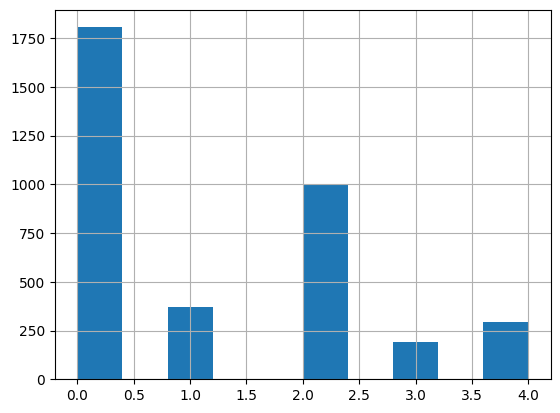

In [11]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

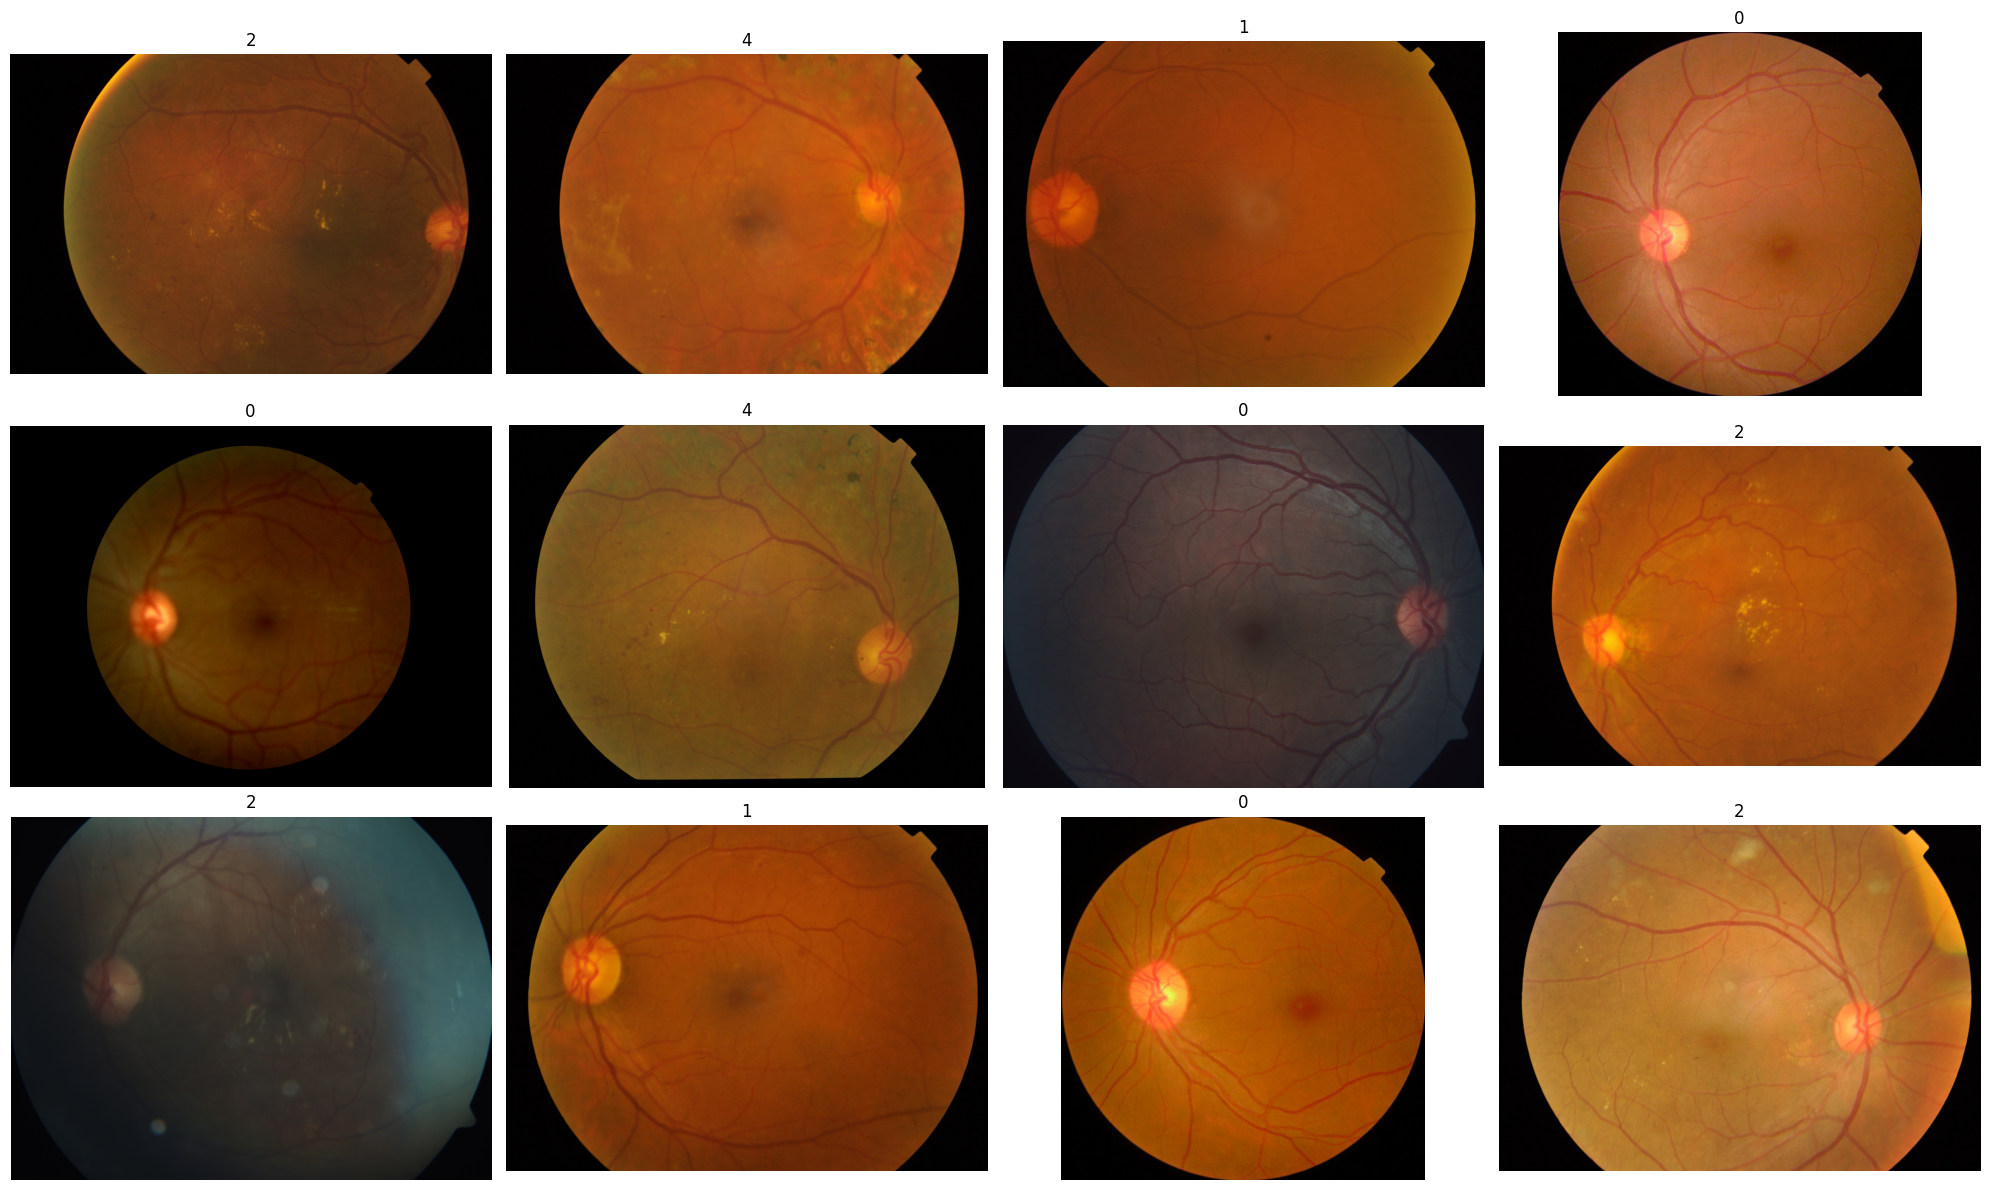

In [12]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'/content/aptos_data/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.axis('off')
        plt.imshow(img)

    plt.tight_layout()

display_samples(train_df)

In [13]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def preprocess_image_with_ben(path, sigmaX=40):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)

    return image

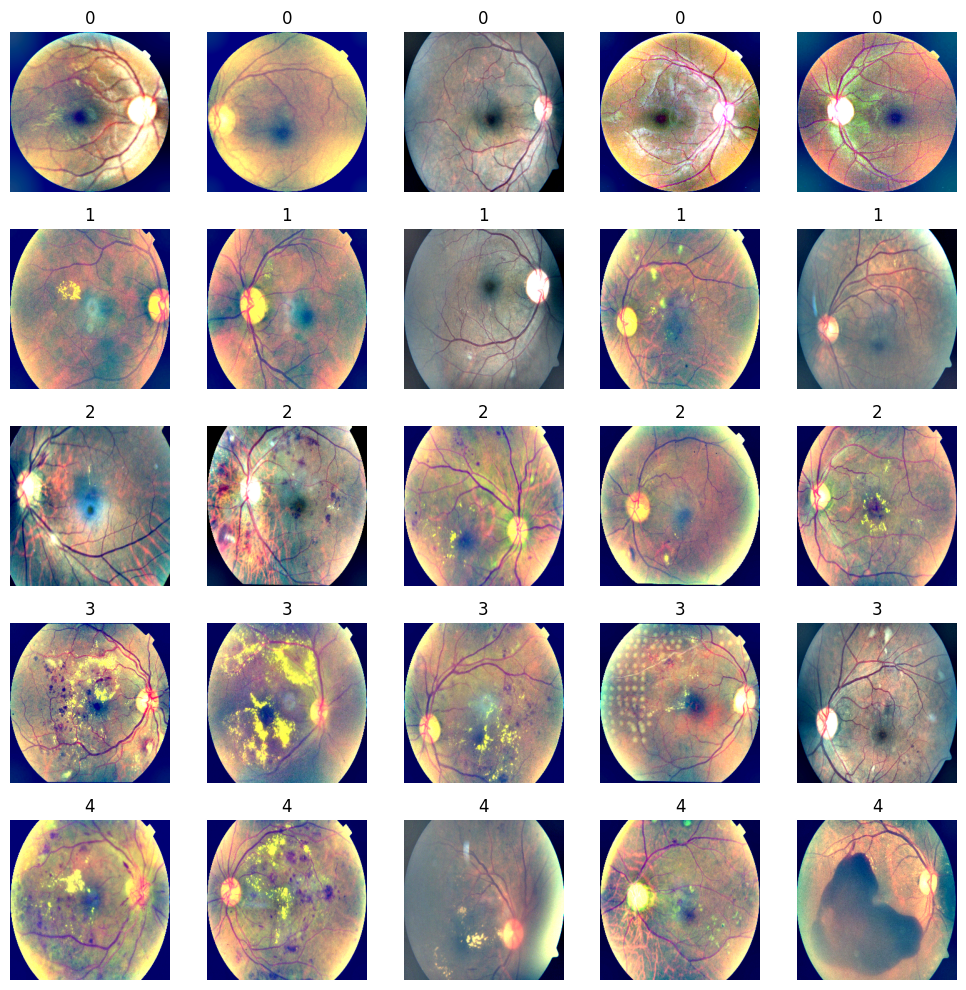

In [14]:
fig,ax=plt.subplots(5,5,figsize=(10,10))
# Get unique diagnosis values from the training data
unique_diagnoses = sorted(train_df['diagnosis'].unique())

# Ensure we don't try to access more subplots than unique diagnoses * 5
# This loop structure assumes you want 5 random samples for each diagnosis level,
# filling a 5x5 grid. If you have fewer than 5 unique diagnoses, the grid won't be full.
# If you have more than 5 unique diagnoses, you'll only display the first 5*5 samples.
# A more robust approach would be to iterate through all unique diagnoses and display
# a fixed number of samples per diagnosis up to the grid size.
# For simplicity and to match the original intent of filling a 5x5 grid from the first 5 diagnoses,
# we'll stick to displaying up to 25 images, iterating through the first 5 unique diagnoses.

# If there are fewer than 5 unique diagnoses, adjust the range for i accordingly
max_i = min(25, len(unique_diagnoses) * 5)

for i in range(max_i):
    # Determine which diagnosis level to plot based on the current index i
    # i // 5 gives the index of the diagnosis level (0 to 4)
    # We use unique_diagnoses[i // 5] to get the actual diagnosis value
    current_diagnosis = unique_diagnoses[i // 5]

    # Filter the dataframe for the current diagnosis level
    data = train_df[train_df['diagnosis'] == current_diagnosis].reset_index()

    # Check if there are any images for this diagnosis level
    if len(data) > 0:
        # Select a random index within the available data for this diagnosis level
        a = np.random.randint(len(data))
        img_code = data['id_code'][a]
        img = preprocess_image_with_ben(path=f'/content/aptos_data/train_images/{img_code}.png')

        # Calculate subplot position
        row = i // 5
        col = i % 5

        ax[row, col].imshow(img)
        ax[row, col].axis('off')
        ax[row, col].set_title(data['diagnosis'][a])
    # If there are no images for this diagnosis, the corresponding subplot will remain empty.

plt.tight_layout()
plt.show()

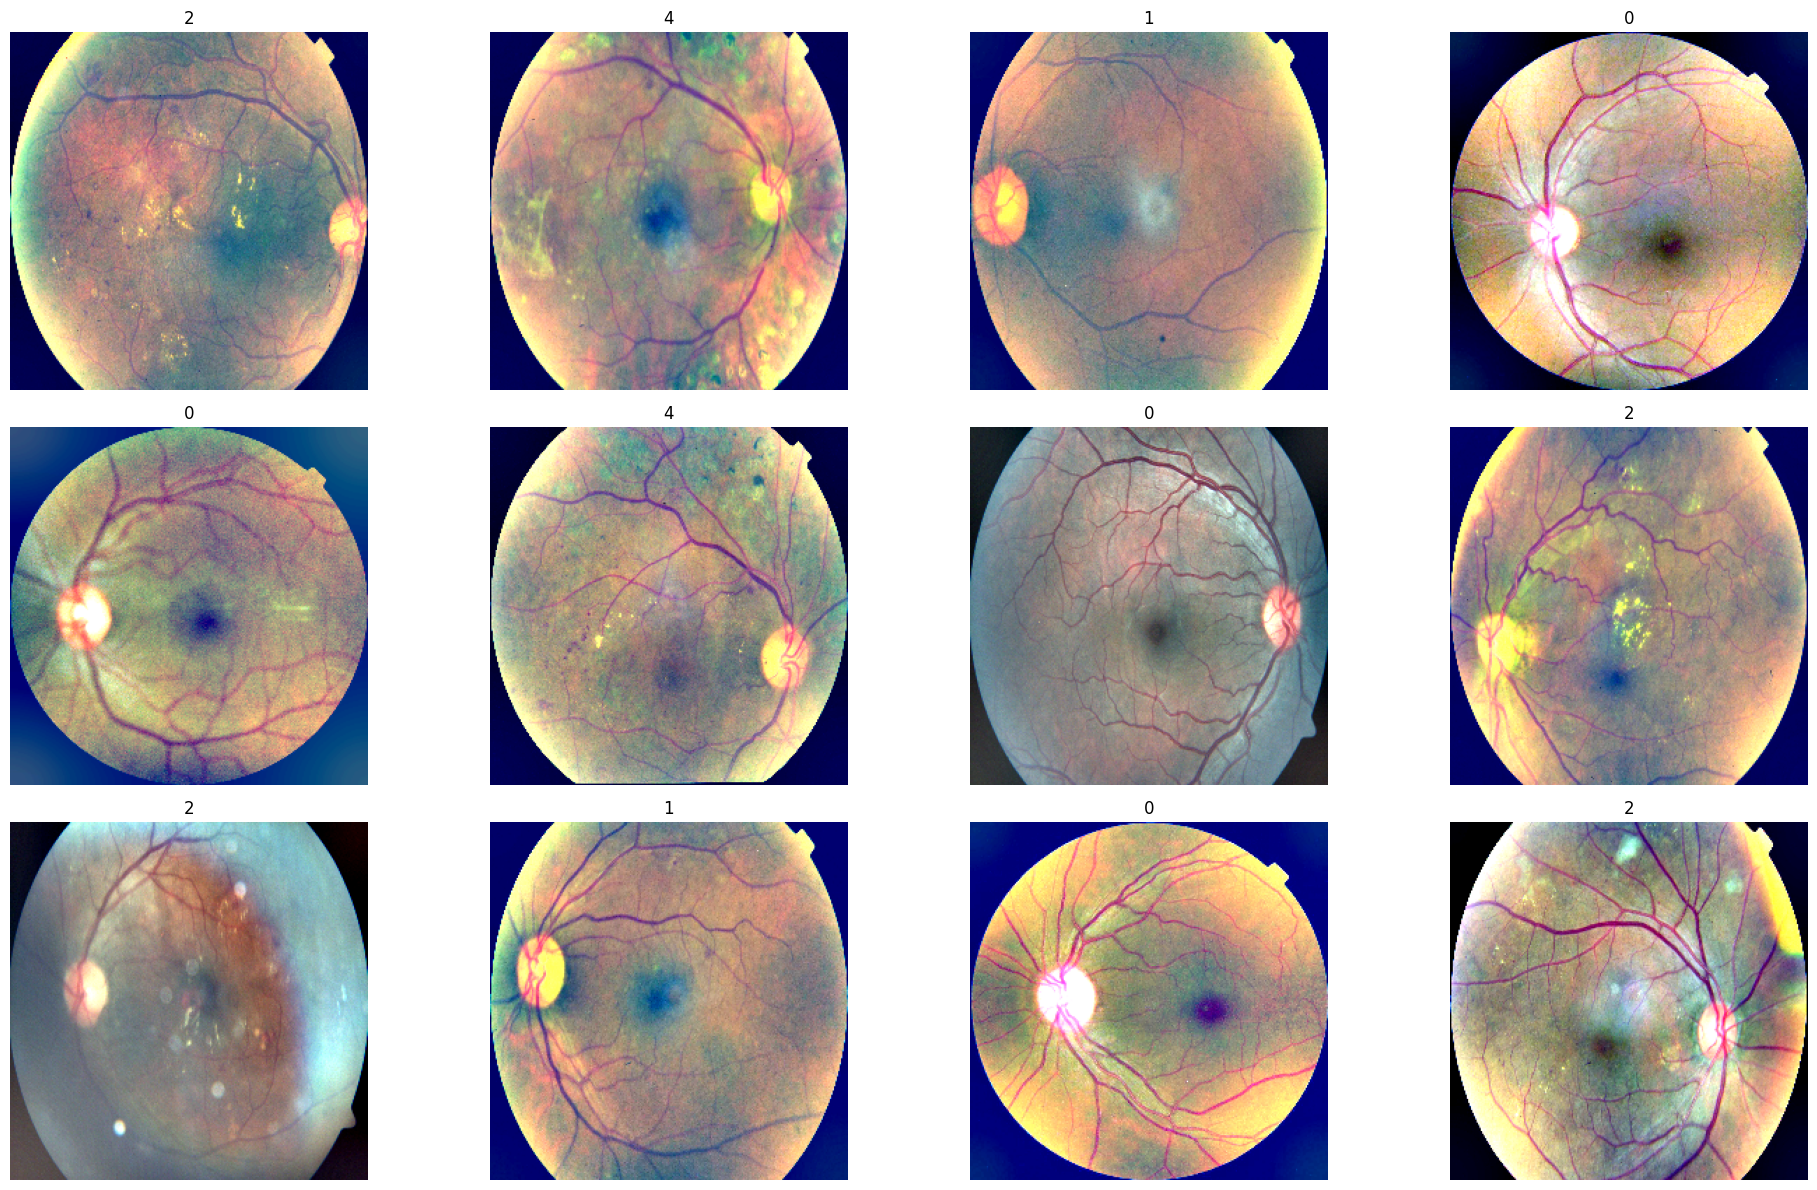

In [18]:
def display_samples_gaussian(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        # Corrected the function call from preprocess_image to preprocess_image_with_ben
        img = preprocess_image_with_ben(f'/content/aptos_data/train_images/{image_path}.png')

        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.axis('off')
        plt.imshow(img)

    plt.tight_layout()

display_samples_gaussian(train_df)

In [19]:
N = train_df.shape[0]
x_train = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image_with_ben(
        f'/content/aptos_data/train_images/{image_id}.png'
    )

100%|██████████| 3662/3662 [24:09<00:00,  2.53it/s]


In [20]:
N = test_df.shape[0]
x_test = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image_with_ben(
        f'/content/aptos_data/test_images/{image_id}.png'
    )

100%|██████████| 1928/1928 [08:49<00:00,  3.64it/s]


In [21]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(3662, 256, 256, 3)
(3662, 5)
(1928, 256, 256, 3)


In [22]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [23]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi,
    test_size=0.15,
    random_state=2019
)

In [24]:
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [25]:
def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE)
# Using Mixup
mixup_generator = MixupGenerator(x_train, y_train, batch_size=BATCH_SIZE, alpha=0.2, datagen=create_datagen())()

In [26]:
true_labels = np.array([1, 0, 1, 1, 0, 1])
pred_labels = np.array([1, 0, 0, 0, 0, 1])

In [27]:
accuracy_score(true_labels, pred_labels)

0.6666666666666666

In [28]:
cohen_kappa_score(true_labels, pred_labels)

np.float64(0.3999999999999999)

In [38]:
from keras.callbacks import Callback
from sklearn.metrics import cohen_kappa_score

class Metrics(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        X_val, y_val = self.validation_data
        y_val = y_val.sum(axis=1) - 1

        y_pred = self.model.predict(X_val, verbose=0) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred,
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")

        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')


In [30]:
densenet = DenseNet121(
    weights='/content/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(IMG_SIZE,IMG_SIZE,3)
)

In [33]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1024,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))

    for layer in model.layers:
        layer.trainable=True

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )

    return model

In [34]:
model = build_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,092,229 (30.87 MB)

 Trainable params: 8,008,581 (30.55 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [40]:
kappa_metrics = Metrics(validation_data=(x_val, y_val))  # Pass validation data explicitly

est=EarlyStopping(monitor='val_loss',patience=5, min_delta=0.005)
call_backs=[kappa_metrics,est]

history = model.fit(
    data_generator,
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    epochs=20,
    callbacks=[kappa_metrics, est],  # include early stopping or others
    validation_data=(x_val, y_val) # Also change here
)

Epoch 1/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9116 - loss: 0.1941

val_kappa: 0.8696
Validation Kappa has improved. Saving model.
194/194 ━━━━━━━━━━━━━━━━━━━━ 142s 728ms/step - accuracy: 0.9115 - loss: 0.1940 - val_accuracy: 0.8909 - val_loss: 0.1360
Epoch 2/20
  1/194 ━━━━━━━━━━━━━━━━━━━━ 45s 236ms/step - accuracy: 0.8125 - loss: 0.1357

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


val_kappa: 0.8673
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8125 - loss: 0.1357 - val_accuracy: 0.8927 - val_loss: 0.1362
Epoch 3/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8830 - loss: 0.1653

val_kappa: 0.9089
Validation Kappa has improved. Saving model.
194/194 ━━━━━━━━━━━━━━━━━━━━ 119s 327ms/step - accuracy: 0.8831 - loss: 0.1653 - val_accuracy: 0.8564 - val_loss: 0.1152
Epoch 4/20
  1/194 ━━━━━━━━━━━━━━━━━━━━ 45s 236ms/step - accuracy: 0.8125 - loss: 0.2373

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


val_kappa: 0.9128
Validation Kappa has improved. Saving model.
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8125 - loss: 0.2373 - val_accuracy: 0.8618 - val_loss: 0.1155
Epoch 5/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8751 - loss: 0.1455val_kappa: 0.8828
194/194 ━━━━━━━━━━━━━━━━━━━━ 76s 328ms/step - accuracy: 0.8751 - loss: 0.1455 - val_accuracy: 0.9018 - val_loss: 0.1244
Epoch 6/20
  1/194 ━━━━━━━━━━━━━━━━━━━━ 35s 183ms/step - accuracy: 0.8750 - loss: 0.1194

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


val_kappa: 0.8818
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8750 - loss: 0.1194 - val_accuracy: 0.9036 - val_loss: 0.1249
Epoch 7/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8913 - loss: 0.1310val_kappa: 0.9101
194/194 ━━━━━━━━━━━━━━━━━━━━ 75s 319ms/step - accuracy: 0.8913 - loss: 0.1310 - val_accuracy: 0.9255 - val_loss: 0.1073
Epoch 8/20
  1/194 ━━━━━━━━━━━━━━━━━━━━ 35s 183ms/step - accuracy: 0.8750 - loss: 0.0656

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


val_kappa: 0.9113
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8750 - loss: 0.0656 - val_accuracy: 0.9200 - val_loss: 0.1073
Epoch 9/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9033 - loss: 0.1148val_kappa: 0.8796
194/194 ━━━━━━━━━━━━━━━━━━━━ 62s 319ms/step - accuracy: 0.9033 - loss: 0.1148 - val_accuracy: 0.9309 - val_loss: 0.1380
Epoch 10/20
  1/194 ━━━━━━━━━━━━━━━━━━━━ 35s 184ms/step - accuracy: 0.9375 - loss: 0.1045

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


val_kappa: 0.8789
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9375 - loss: 0.1045 - val_accuracy: 0.9309 - val_loss: 0.1386
Epoch 11/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8984 - loss: 0.1122val_kappa: 0.8752
194/194 ━━━━━━━━━━━━━━━━━━━━ 63s 325ms/step - accuracy: 0.8984 - loss: 0.1122 - val_accuracy: 0.9418 - val_loss: 0.1627
Epoch 12/20
  1/194 ━━━━━━━━━━━━━━━━━━━━ 35s 185ms/step - accuracy: 0.8125 - loss: 0.0499

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


val_kappa: 0.8781
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8125 - loss: 0.0499 - val_accuracy: 0.9400 - val_loss: 0.1589


<Axes: >

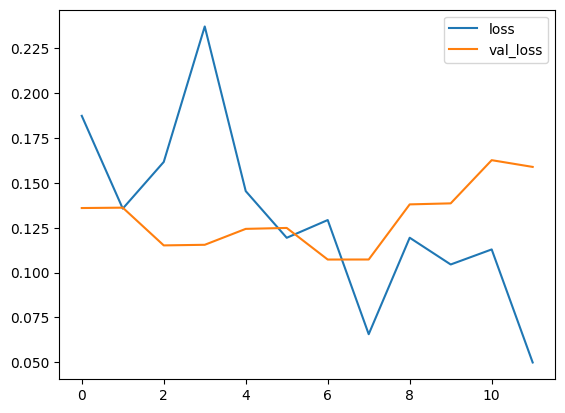

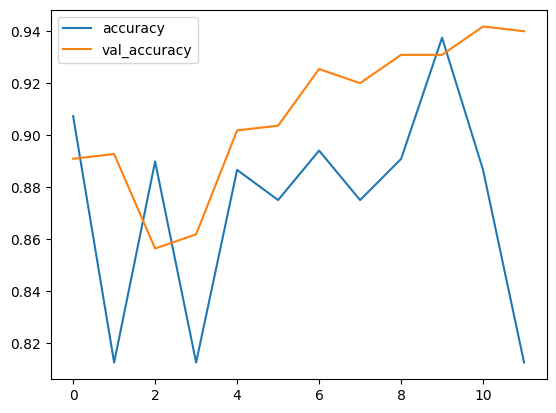

In [42]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
# Corrected column names from 'acc' and 'val_acc' to 'accuracy' and 'val_accuracy'
history_df[['accuracy', 'val_accuracy']].plot()

In [43]:
model.load_weights('model.h5')
y_val_pred = model.predict(x_val)

def compute_score_inv(threshold):
    y1 = y_val_pred > threshold
    y1 = y1.astype(int).sum(axis=1) - 1
    y2 = y_val.sum(axis=1) - 1
    score = cohen_kappa_score(y1, y2, weights='quadratic')

    return 1 - score

simplex = scipy.optimize.minimize(
    compute_score_inv, 0.5, method='nelder-mead'
)

best_threshold = simplex['x'][0]

print('Best threshold is : ',best_threshold)

print('Validation QWK score: ',(1-compute_score_inv(best_threshold)))

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step
Best threshold is :  0.490625
Validation QWK score:  0.9141822627668579


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step


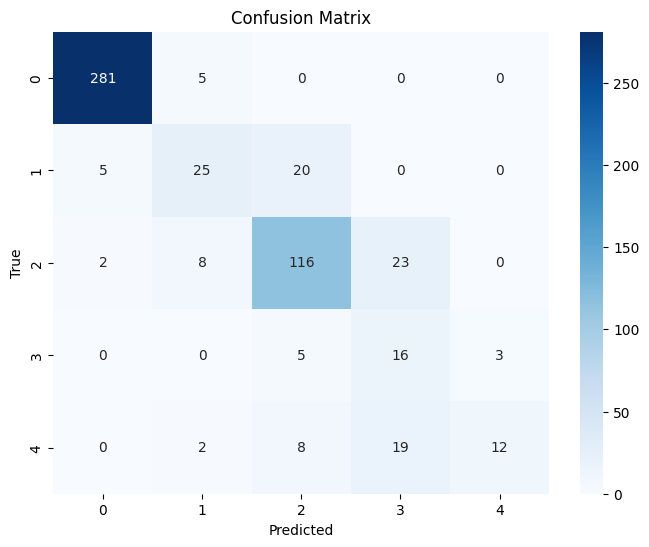

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example: Get predictions
# Changed X_val to x_val to match the variable used during validation split
y_pred_probs = model.predict(x_val)
# For multiclass classification, argmax might not be directly applicable here
# since y_val is in multilabel format (e.g., True for all classes up to the actual label).
# Instead of argmax, let's use the thresholding approach consistent with the kappa calculation.
# y_pred = y_pred_probs.argmax(axis=1) # Original argmax line

# Apply the best threshold found previously
# Ensure best_threshold is available in this scope, or re-calculate it if necessary
# Assuming best_threshold was calculated in the previous cell and is still available
try:
    best_threshold
except NameError:
    print("Warning: best_threshold is not defined. Using default 0.5. Run the previous cell to optimize.")
    best_threshold = 0.5 # Default threshold if not found

y_pred = (y_pred_probs > best_threshold).astype(int).sum(axis=1) - 1 # Use thresholding
y_true = y_val.astype(int).sum(axis=1) - 1 # Convert true labels to single class index

# Compute confusion matrix
# Ensure that both y_true and y_pred have integer values corresponding to class labels (0, 1, 2, 3, 4)
# If y_true and y_pred contain other values, this might cause issues or unexpected matrix size.
# Let's check the unique values to be sure.
# print("Unique y_true values:", np.unique(y_true))
# print("Unique y_pred values:", np.unique(y_pred))

cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn heatmap
plt.figure(figsize=(8, 6))
# Ensure tick labels are correctly set to the class indices (0-4)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [47]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# If predictions are probabilities, convert to class indices
# Corrected X_val to x_val to match the variable used throughout the notebook
y_pred_probs = model.predict(x_val)
# For multiclass classification, argmax might not be directly applicable here
# since y_val is in multilabel format (e.g., True for all classes up to the actual label).
# Instead of argmax, let's use the thresholding approach consistent with the kappa calculation.
# If using the optimized threshold from the previous cell:
try:
    best_threshold
except NameError:
    print("Warning: best_threshold is not defined. Using default 0.5 for argmax.")
    # If you want to use argmax for classification report,
    # you might want to reconsider the multiclass vs multilabel approach
    # or convert your ground truth labels to a single class index using argmax as well.
    # For consistency with the confusion matrix and kappa score logic (sum(axis=1) - 1),
    # let's apply thresholding here too for generating y_pred.
    # If best_threshold is not available, using 0.5 is a common default.
    best_threshold = 0.5 # Default threshold if not found

# Apply the thresholding logic used for kappa and confusion matrix
y_pred = (y_pred_probs > best_threshold).astype(int).sum(axis=1) - 1 # Use thresholding

# Convert y_val (multilabel format) to single class index for classification report
# The classification report expects single class labels for y_true and y_pred
y_true = y_val.astype(int).sum(axis=1) - 1

# Ensure y_true and y_pred have consistent labels (0-4) for classification report
# If you have samples with label 0, the sum(axis=1) - 1 will be -1.
# Let's handle this to ensure labels are in the range [0, 4].
y_true = np.maximum(0, y_true)
y_pred = np.maximum(0, y_pred)

# You might also want to clip values to ensure they are within the expected range [0, 4]
y_true = np.clip(y_true, 0, 4)
y_pred = np.clip(y_pred, 0, 4)


# Full classification report
print("Classification Report:\n")
# Ensure labels argument is passed to classification_report for clarity
# The labels are 0, 1, 2, 3, 4
print(classification_report(y_true, y_pred, labels=range(5), target_names=[str(i) for i in range(5)]))

# OR: Get individual metrics
precision = precision_score(y_true, y_pred, average='macro')  # or 'micro', 'weighted'
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")



18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       286
           1       0.62      0.50      0.56        50
           2       0.78      0.78      0.78       149
           3       0.28      0.67      0.39        24
           4       0.80      0.29      0.43        41

    accuracy                           0.82       550
   macro avg       0.69      0.64      0.63       550
weighted avg       0.85      0.82      0.82       550

Precision: 0.6910
Recall:    0.6441
F1-score:  0.6264
